Import necessary libraries

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from collections import defaultdict,Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly
from plotly.subplots import make_subplots
from nltk.tokenize import word_tokenize
import plotly.figure_factory as ff
from nltk.corpus import stopwords
from nltk.corpus import stopwords
import plotly.graph_objects as go
from textblob import TextBlob
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from nltk.util import ngrams
import plotly.offline as py
import plotly.express as px
from statistics import *
from plotly import tools
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import textstat
import string
import json
import nltk
import gc
import re

Import the training dataset

In [38]:
data = pd.read_csv("movies_metadata.csv")
data.head()

/home/chi/anaconda3/envs/nltkENv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


WordCloud

Text(0.5, 1.0, 'overview')

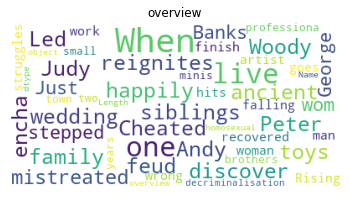

In [40]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
    background_color = 'white',
    stopwords =stopwords,
    max_words = 200,
    max_font_size = 40,
    random_state = 42).generate(str(data['overview']))

plt.imshow(wordcloud)
plt.axis('off')
plt.title('overview')

Text(0.5, 1.0, 'tagline')

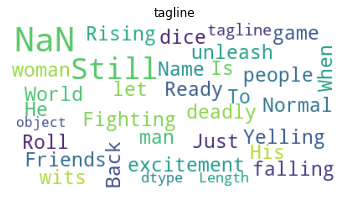

In [41]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
    background_color = 'white',
    stopwords =stopwords,
    max_words = 200,
    max_font_size = 40,
    random_state = 42).generate(str(data['tagline']))

plt.imshow(wordcloud)
plt.axis('off')
plt.title('tagline')

Data Cleaning

In [42]:
def cleaning(s):
    s = str(s)
    s = s.lower()
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub(r'[^\w]', ' ', s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_]', '', s)
    s = s.replace("co","")
    s = s.replace("https","")
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    return s


data['overview'] = [cleaning(s) for s in data['overview']]
data['tagline'] = [cleaning(s) for s in data['tagline']]
    

Tf-idf and Kmeans

In [43]:
vectorizer = TfidfVectorizer(stop_words = 'english', use_idf = True)
model = vectorizer.fit_transform(data['overview'].str.upper())

km = KMeans(n_clusters=5, init='k-means++', max_iter=200, n_init=1)
#km = KMeans(n_cluster = 5, init = 'k-means++', max_iter = 200, n_init = 1)

km = km.fit(model)
terms = vectorizer.get_feature_names()

order_centroids = km.cluster_centers_.argsort()[:,::-1]

#order_centroids = km.cluster_cluster_.argsort()[:,::-1]

for i in range(5):
    print("cluster of words %d:" %i)
    for ind in order_centroids[i,:10]:
        print(' %s' % terms[ind])
    print() 

cluster of words 0:
 family
 life
 home
 father
 new
 young
 mother
 man
 old
 son

cluster of words 1:
 nan
 gronski
 groomed
 groomer
 grooming
 grooms
 groomsmen
 groot
 grootste
 첫사랑

cluster of words 2:
 film
 world
 story
 war
 documentary
 new
 group
 life
 people
 american

cluster of words 3:
 life
 love
 old
 school
 new
 girl
 year
 father
 town
 mother

cluster of words 4:
 young
 man
 woman
 love
 life
 story
 finds
 husband
 wife
 girl



Building corpus  

In [44]:
def build_corpus(data):
    corpus = []
    for col in['tagline', 'overview']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
            
    return corpus

corpus = build_corpus(data)
corpus[0:2]

[['nan'], ['roll', 'the', 'dice', 'and', 'unleash', 'the', 'excitement', '']]

Words to Vector

In [45]:
model = word2vec.Word2Vec(corpus, size = 100, window = 20, min_count = 400, workers = 4)
model.wv['states']

array([-0.10943754,  0.07087444, -0.2628488 , -0.36655238, -3.3174396 ,
       -1.5342569 ,  2.8689804 , -1.4135835 ,  2.8248377 ,  0.6738981 ,
        3.3308983 ,  0.90470415, -0.6176172 ,  0.8877777 , -0.18307589,
       -0.4654079 , -0.6049648 ,  0.21704085,  1.3568859 ,  0.17339659,
       -0.06144964, -0.20242518,  0.5391772 ,  0.7996889 ,  0.34811324,
        0.5682164 ,  0.634135  , -0.043292  ,  0.16679783,  1.2504479 ,
       -2.3612006 , -0.11748494, -0.7493984 , -2.242656  ,  0.25433987,
       -1.3317987 , -0.45666698,  0.1530384 ,  0.4416151 ,  2.3236535 ,
       -1.7806122 , -0.71274316,  0.02343083,  0.05043804, -1.3573806 ,
        0.8418619 , -0.61470836, -1.2409012 , -0.3824655 ,  0.01445806,
       -0.32469139,  1.6251006 , -0.55732447, -0.06285226, -0.73510605,
       -1.0161191 , -0.10555721,  0.60733646,  0.2907216 ,  0.65153605,
        0.49996707,  1.335107  , -1.597484  , -0.11108164,  1.0570374 ,
       -0.20002124, -1.2749889 ,  0.534141  ,  0.47682467,  0.50

Data Visualization

In [46]:
def tsne_plot(model):
    labels = []
    tokens =[]
    
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        
        
    tsne_model = TSNE(perplexity = 40,
                     n_components = 2, init = 'pca',
                     n_iter = 2500, random_state = 23)
    
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
        
        
    plt.figure(figsize = (16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                    xy = (x[i], y[i]),
                    xytext = (5, 2),
                    textcoords = 'offset points',
                    ha = 'right',
                    va = 'bottom')
        
    plt.show()   

/home/chi/anaconda3/envs/nltkENv/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



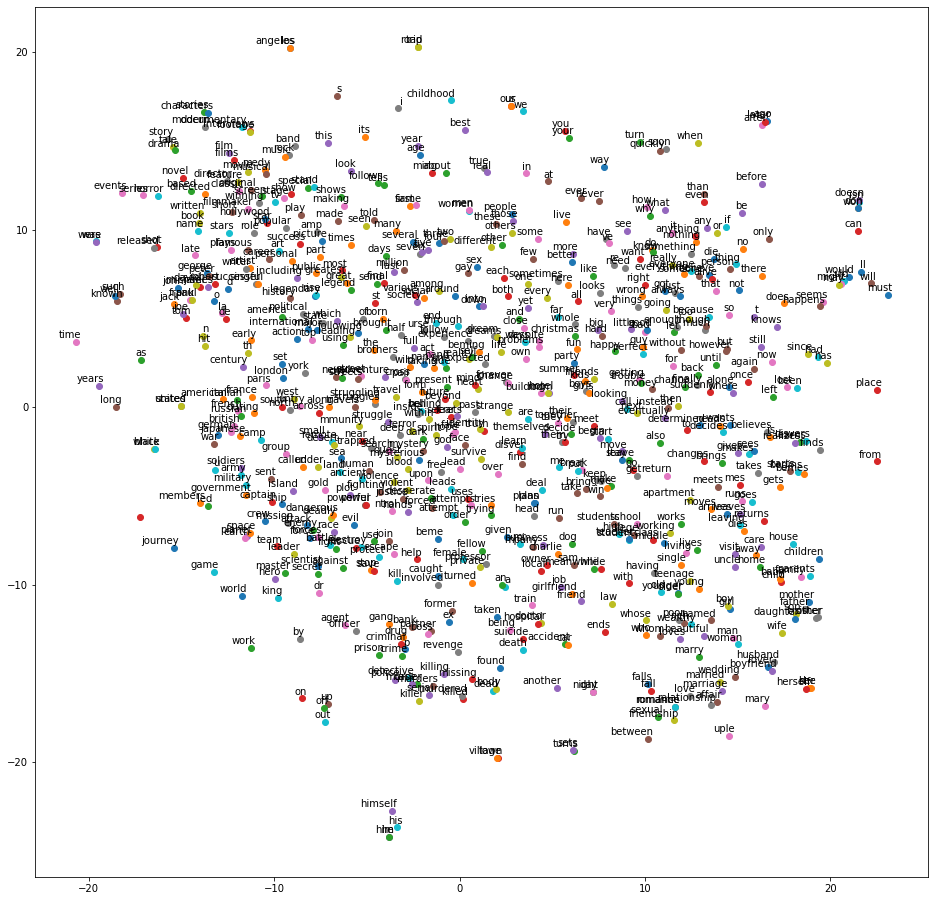

In [47]:
tsne_plot(model)